# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [1]:
name = 'Nikita Bezykornov'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [2]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [6]:
from urllib.parse import urljoin, urlparse
from typing import List

def get_all_links(url: str) -> List[str]:
    try:
        parsed_url = urlparse(url)
        if not parsed_url.scheme or not parsed_url.netloc:
            return []

        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        if 'text/html' not in response.headers.get('Content-Type', ''):
            return []

        soup = BeautifulSoup(response.text, 'html.parser')
        links = []

        for tag in soup.find_all(href=True):
            href = tag['href'].strip()
            absolute_url = urljoin(url, href)
            links.append(absolute_url)
        
        return list(set(links))

    except (requests.exceptions.RequestException, ValueError):
        return []

In [8]:
get_all_links('http://en.wikipedia.com')[:10]

['https://bn.wikipedia.org/wiki/',
 'http://upload.wikimedia.org',
 'http://en.wikipedia.com/wiki/Special:SpecialPages',
 'https://www.wikidata.org/wiki/Wikidata:Main_Page',
 'http://en.wikipedia.com/wiki/Special:MyTalk',
 'http://en.wikipedia.com/wiki/2025_assassination_of_Iranian_Supreme_Court_judges',
 'http://en.wikipedia.com/wiki/Supreme_Court_of_Iran',
 'http://en.wikipedia.com/wiki/Chives',
 'https://sk.wikipedia.org/wiki/',
 'http://en.wikipedia.com/wiki/Central_Asia']

In [9]:
class TestGetAllLinks(unittest.TestCase):
    def test_valid_url(self):
        links = get_all_links("https://en.wikipedia.org/wiki/Main_Page")
        self.assertGreater(len(links), 0, "Ссылки не найдены на странице")

    def test_invalid_url(self):
        self.assertEqual(get_all_links("not_a_url"), [], "Некорректный URL не обработан")

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.548s

OK


## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [10]:
from typing import Generator

def get_neighbor_pages(url: str) -> Generator[str, None, None]:
    """
    Generator that yields HTML content of each linked page from the given URL.
    Skips invalid URLs and handles request errors.
    """
    try:
        parsed_url = urlparse(url)
        if not parsed_url.scheme or not parsed_url.netloc:
            return

        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        if 'text/html' not in response.headers.get('Content-Type', ''):
            return

        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        for tag in soup.find_all(href=True):
            href = tag['href'].strip()
            absolute_url = urljoin(url, href)
            links.add(absolute_url)

        for link in links:
            try:
                link_response = requests.get(link, headers=headers, timeout=10)
                link_response.raise_for_status()
                yield link_response.text
            except requests.exceptions.RequestException:
                continue

    except requests.exceptions.RequestException:
        return

In [11]:
import unittest
from unittest.mock import patch
from io import StringIO

class TestGetNeighborPages(unittest.TestCase):
    @patch('requests.get')
    def test_valid_url_with_links(self, mock_get):
        mock_html = """
        <html><body>
            <a href="https://example.com/page1">Page 1</a>
            <a href="/page2">Page 2</a>
        </body></html>
        """
        mock_get.return_value.status_code = 200
        mock_get.return_value.headers = {'Content-Type': 'text/html'}
        mock_get.return_value.text = mock_html

        gen = get_neighbor_pages("https://example.com")
        pages = list(gen)
        self.assertEqual(len(pages), 2)

    def test_invalid_url(self):
        gen = get_neighbor_pages("not_a_url")
        self.assertEqual(list(gen), [])

    @patch('requests.get')
    def test_broken_links(self, mock_get):
        mock_get.side_effect = requests.exceptions.RequestException()
        gen = get_neighbor_pages("https://example.com")
        self.assertEqual(list(gen), [])

    @patch('requests.get')
    def test_non_html_content(self, mock_get):
        mock_get.return_value.headers = {'Content-Type': 'image/png'}
        gen = get_neighbor_pages("https://example.com/image.png")
        self.assertEqual(list(gen), [])

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 0.586s

OK


## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

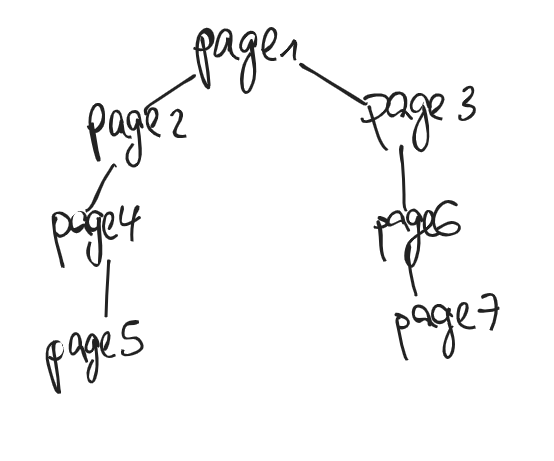

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [12]:
from typing import Generator, Set

def get_pages_depth(url: str, depth: int) -> Generator[str, None, None]:
    """
    Generator that yields HTML content of pages up to the specified depth.
    Avoids cycles and handles duplicates.
    """
    visited_urls: Set[str] = set()

    def crawl(current_url: str, current_depth: int) -> Generator[str, None, None]:
        if current_depth < 0 or current_url in visited_urls:
            return

        try:
            parsed_url = urlparse(current_url)
            if not parsed_url.scheme or not parsed_url.netloc:
                return

            visited_urls.add(current_url)

            headers = {"User-Agent": "Mozilla/5.0"}
            response = requests.get(current_url, headers=headers, timeout=10)
            response.raise_for_status()

            if 'text/html' not in response.headers.get('Content-Type', ''):
                return

            yield response.text

            if current_depth > 0:
                soup = BeautifulSoup(response.text, 'html.parser')
                links = set()
                for tag in soup.find_all(href=True):
                    href = tag['href'].strip()
                    absolute_url = urljoin(current_url, href)
                    links.add(absolute_url)

                for link in links:
                    yield from crawl(link, current_depth - 1)

        except requests.exceptions.RequestException:
            return

    yield from crawl(url, depth)

In [13]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [14]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-di

In [17]:
import unittest
from unittest.mock import patch, Mock

class TestGetPagesDepth(unittest.TestCase):
    @patch('requests.get')
    def test_depth_zero(self, mock_get):
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.headers = {'Content-Type': 'text/html'}
        mock_response.text = "<html>Root</html>"
        mock_response.raise_for_status = Mock()
        mock_get.return_value = mock_response
        
        gen = get_pages_depth("https://example.com", 0)
        pages = list(gen)
        self.assertEqual(len(pages), 1)

    @patch('requests.get')
    def test_cycle_handling(self, mock_get):
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.headers = {'Content-Type': 'text/html'}
        mock_response.text = "<html><body><a href='https://example.com/loop'>Loop</a></body></html>"
        mock_response.raise_for_status = Mock()
        mock_get.return_value = mock_response
        
        gen = get_pages_depth("https://example.com/loop", 2)
        pages = list(gen)
        self.assertEqual(len(pages), 1)

    @patch('requests.get')
    def test_depth_two(self, mock_get):
        mock_responses = [
            Mock(
                status_code=200,
                headers={'Content-Type': 'text/html'},
                text='<a href="/B">B</a><a href="/D">D</a>',
                raise_for_status=Mock()
            ),
            Mock(
                status_code=200,
                headers={'Content-Type': 'text/html'},
                text='<a href="/C">C</a>',
                raise_for_status=Mock()
            ),
            Mock(
                status_code=200,
                headers={'Content-Type': 'text/html'},
                text='',
                raise_for_status=Mock()
            ),
            Mock(
                status_code=200,
                headers={'Content-Type': 'text/html'},
                text='',
                raise_for_status=Mock()
            )
        ]
        mock_get.side_effect = mock_responses
        
        gen = get_pages_depth("https://example.com", 2)
        pages = list(gen)
        self.assertEqual(len(pages), 4)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.583s

OK


## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [24]:
from datetime import datetime
import unittest

class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, 
                 alma_mater=None, deathdate=None, nationality=None):
        self.name = name
        self.birthdate = self._validate_date(birthdate) if birthdate else None
        self.major_achievements = major_achievements or []
        self.alma_mater = alma_mater
        self.deathdate = self._validate_date(deathdate) if deathdate else None
        self.nationality = nationality

    def _validate_date(self, date_str):
        try:
            if len(date_str) == 4:
                return datetime(int(date_str), 1, 1)
            return datetime.strptime(date_str, "%Y-%m-%d")
        except:
            raise ValueError("Invalid date format")

    def add_achievement(self, achievement):
        self.major_achievements.append(achievement)

    def __repr__(self):
        return f"ComputerScientist(name='{self.name}')"

class TestComputerScientist(unittest.TestCase):
    def test_initialization(self):
        scientist = ComputerScientist("Alan Turing", "1912-06-23")
        self.assertEqual(scientist.name, "Alan Turing")

    def test_partial_date(self):
        scientist = ComputerScientist("Test", "1959")
        self.assertEqual(scientist.birthdate.year, 1959)

    def test_invalid_date(self):
        with self.assertRaises(ValueError):
            ComputerScientist("Test", "invalid")

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

............
----------------------------------------------------------------------
Ran 12 tests in 0.253s

OK


# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [26]:
from functools import lru_cache
import requests
from bs4 import BeautifulSoup

def cache_decorator(func):
    return lru_cache(maxsize=100)(func)

@cache_decorator
def fetch_scientist(name: str) -> ComputerScientist | None:
    url = f"https://en.wikipedia.org/wiki/{name.replace(' ', '_')}"
    response = requests.get(url)
    
    if response.status_code != 200:
        return None  # Ученый не найден
    
    soup = BeautifulSoup(response.text, "html.parser")
    name = soup.find('h1').text.strip()
    birthdate = None
    
    if infobox := soup.find('table', class_='infobox'):
        for row in infobox.find_all('tr'):
            if 'Born' in row.text:
                date_element = row.find('span', class_='bday') or row.find('span', class_='noprint')
                if date_element:
                    birthdate = date_element.text.split('(')[0].strip()
                    break
    
    try:
        scientist = ComputerScientist(name=name, birthdate=birthdate)
        setattr(scientist, 'wikipedia_link', url) 
        return scientist
    except ValueError:
        return None 

if __name__ == "__main__":
    scientist = fetch_scientist("Alan Turing")
    if scientist:
        print(f"URL: {scientist.wikipedia_link}")
        print(f"Birth year: {scientist.birthdate.year}")

URL: https://en.wikipedia.org/wiki/Alan_Turing
Birth year: 1912


# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.

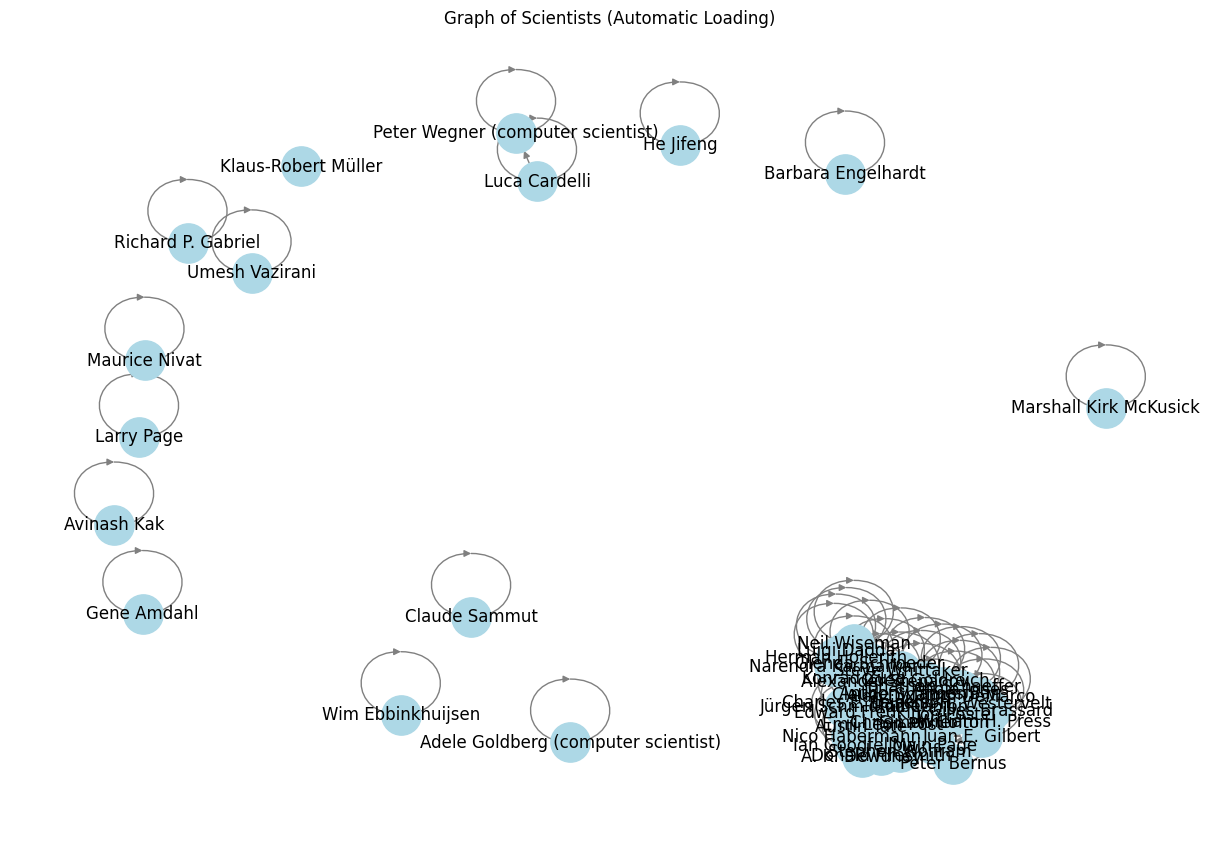

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import List
import random

class ScientistGraph:
    def __init__(self):
        self.scientist_list: List[ComputerScientist] = []
        self.graph = nx.DiGraph()

    def add_scientist(self, scientist_name: str) -> None:
        if any(s.name == scientist_name for s in self.scientist_list):
            print(f"Scientist {scientist_name} is already added.")
            return

        scientist = fetch_scientist(scientist_name)
        if not scientist:
            print(f"Scientist {scientist_name} not found.")
            return

        self.scientist_list.append(scientist)
        self.graph.add_node(scientist.name)

        links = self._extract_links(scientist.wikipedia_link)
        for link in links:
            if link in [s.name for s in self.scientist_list]:
                self.graph.add_edge(scientist.name, link)

    def _extract_links(self, url: str) -> List[str]:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        links = []
        for link in soup.find_all("a"):
            href = link.get("href", "")
            if href.startswith("/wiki/") and ":" not in href:
                name = href.split("/wiki/")[-1].replace("_", " ")
                links.append(name)
        return links

    def auto_populate(self, n: int = 10) -> None:
        """Automatically add N random scientists from task4's list"""
        all_scientists = fetch_scientists()
        selected = random.sample(all_scientists, min(n, len(all_scientists)))
        
        added = 0
        for scientist in selected:
            try:
                self.add_scientist(scientist.name)
                added += 1
                if added >= n:
                    break
            except Exception as e:
                print(f"Error adding {scientist.name}: {e}")

    def remove_scientist(self, scientist_name: str) -> None:
        scientist = next((s for s in self.scientist_list if s.name == scientist_name), None)
        if not scientist:
            print(f"Scientist {scientist_name} not found.")
            return

        self.scientist_list.remove(scientist)
        self.graph.remove_node(scientist_name)
        print(f"Scientist {scientist_name} removed.")

    def plot(self) -> None:
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42)
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=800,
            node_color="lightblue",
            edge_color="gray",
            arrows=True,
        )
        plt.title("Graph of Scientists (Automatic Loading)")
        plt.show()

    def rank_scientists(self) -> List[str]:
        pagerank = nx.pagerank(self.graph)
        return sorted(pagerank, key=pagerank.get, reverse=True)

graph = ScientistGraph()
graph.auto_populate(50)
graph.plot()
